# ** Importing Libraries**

In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score,cohen_kappa_score,matthews_corrcoef,SCORERS
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,BernoulliNB

from xgboost import XGBClassifier 
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Data Preprocessing

In [0]:
from google.colab import files
file=files.upload()

Saving PatientData.csv to PatientData (1).csv


In [0]:
data=pd.read_csv('PatientData.csv')
data.head()

,gender,age,diabetes,hypertension,stroke,heart disease,smoking history,BMI
0,Female,80.0,0,0,0,1,never,25.19
1,Female,54.0,0,0,0,0,NaN,NaN
2,Male,28.0,0,0,0,0,never,NaN
3,Female,36.0,0,0,0,0,current,23.45
4,Male,76.0,0,1,0,1,current,20.14


In [0]:
data.isna().sum()

gender                 0
age                    0
diabetes               0
hypertension           0
stroke                 0
heart disease          0
smoking history    35816
BMI                25444
dtype: int64

In [0]:
data.dtypes

gender              object
age                float64
diabetes             int64
hypertension         int64
stroke               int64
heart disease        int64
smoking history     object
BMI                float64
dtype: object

In [0]:
data.corr()

,age,diabetes,hypertension,stroke,heart disease,BMI
age,1.000000,0.258008,0.251171,0.143748,0.233354,0.387541
diabetes,0.258008,1.000000,0.197823,0.086132,0.171727,0.237774
hypertension,0.251171,0.197823,1.000000,0.077651,0.121262,0.162858
stroke,0.143748,0.086132,0.077651,1.000000,0.102201,0.028356
heart disease,0.233354,0.171727,0.121262,0.102201,1.000000,0.068643
BMI,0.387541,0.237774,0.162858,0.028356,0.068643,1.000000


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

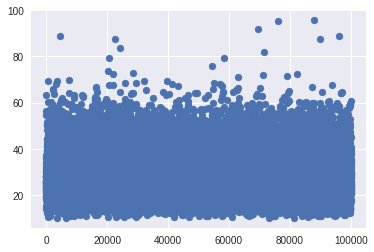

In [0]:
plt.scatter(data.index,data.BMI)

In [0]:
data['smoking history']=data['smoking history'].fillna('Unknown')

In [0]:
data['smoking history'].value_counts()

Unknown        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking history, dtype: int64

In [0]:
train_data_cat=data.select_dtypes(include=[object])
train_data_num=data.select_dtypes(exclude=[object])
train_data_cat=pd.get_dummies(train_data_cat, columns=train_data_cat.columns, drop_first=True)
data_df=pd.concat([train_data_cat,train_data_num],axis=1)

In [0]:
data_df.head()

,gender_Male,gender_Other,smoking history_current,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,stroke,heart disease,BMI
0,0,0,0,0,0,1,0,80.0,0,0,0,1,25.19
1,0,0,0,0,0,0,0,54.0,0,0,0,0,NaN
2,1,0,0,0,0,1,0,28.0,0,0,0,0,NaN
3,0,0,1,0,0,0,0,36.0,0,0,0,0,23.45
4,1,0,1,0,0,0,0,76.0,0,1,0,1,20.14


In [0]:
from fancyimpute import IterativeImputer

Using TensorFlow backend.


In [0]:
XY_incomplete = data_df.copy()

In [0]:
data_complete_df = pd.DataFrame(IterativeImputer(n_iter=20, sample_posterior=True, random_state=8).fit_transform(XY_incomplete))

In [0]:
data_complete_df.columns=data_df.columns

In [0]:
data_complete_df.head()

,gender_Male,gender_Other,smoking history_current,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,stroke,heart disease,BMI
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,0.0,0.0,1.0,25.190000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,18.982447
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0.0,0.0,0.0,0.0,27.603525
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,23.450000
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,76.0,0.0,1.0,0.0,1.0,20.140000


In [0]:
data_complete_df.shape

(100000, 13)

In [0]:
data_complete_df['diabetes & hypertension']=data_complete_df['diabetes']*data_complete_df['hypertension']
data_complete_df['diabetes & srtoke']=data_complete_df['diabetes']*data_complete_df['stroke']
data_complete_df['diabetes & heart disease']=data_complete_df['diabetes']*data_complete_df['heart disease']
data_complete_df['hypertension & stroke']=data_complete_df['hypertension']*data_complete_df['stroke']
data_complete_df['hypertension & heart disease']=data_complete_df['hypertension']*data_complete_df['heart disease']
data_complete_df['stroke & heart disease']=data_complete_df['stroke']*data_complete_df['heart disease']

In [0]:
data_complete_df['diabetes,hypertension,stroke']=data_complete_df['diabetes']*data_complete_df['hypertension']*data_complete_df['stroke']
data_complete_df['diabetes,hypertension,heart disease']=data_complete_df['diabetes']*data_complete_df['hypertension']*data_complete_df['heart disease']
data_complete_df['hypertension,stroke,heart disease']=data_complete_df['hypertension']*data_complete_df['stroke']*data_complete_df['heart disease']

In [0]:
data_complete_df['hypertension,stroke,heart disease,diabetes']=data_complete_df['hypertension']*data_complete_df['stroke']*data_complete_df['heart disease']*data_complete_df['diabetes']

In [0]:
data_complete_df.shape

(100000, 23)

In [0]:
data_complete_df.head()

,gender_Male,gender_Other,smoking history_current,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,...,diabetes & hypertension,diabetes & srtoke,diabetes & heart disease,hypertension & stroke,hypertension & heart disease,stroke & heart disease,"diabetes,hypertension,stroke","diabetes,hypertension,heart disease","hypertension,stroke,heart disease","hypertension,stroke,heart disease,diabetes"
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,76.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

(array([ 8981.,  7220.,  9684., 10368., 10619., 11669., 12136., 10755.,
         7873., 10695.]),
 array([ 0.08 ,  8.072, 16.064, 24.056, 32.048, 40.04 , 48.032, 56.024,
        64.016, 72.008, 80.   ]),
 <a list of 10 Patch objects>)

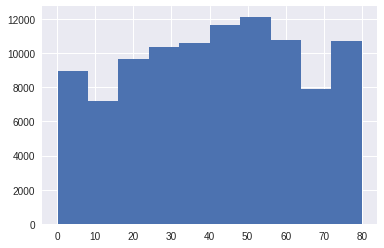

In [0]:
plt.hist(data['age'])

(array([8.6570e+03, 3.1394e+04, 2.4929e+04, 7.3890e+03, 1.7160e+03,
        3.7900e+02, 7.3000e+01, 8.0000e+00, 4.0000e+00, 7.0000e+00]),
 array([10.01 , 18.578, 27.146, 35.714, 44.282, 52.85 , 61.418, 69.986,
        78.554, 87.122, 95.69 ]),
 <a list of 10 Patch objects>)

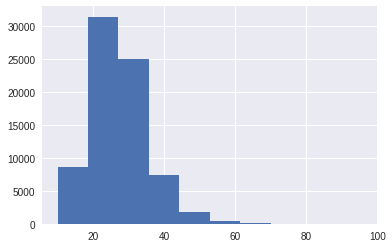

In [0]:
plt.hist(data['BMI'])

In [0]:
data_complete_df['stroke'].value_counts()

0.0    98574
1.0     1426
Name: stroke, dtype: int64

# ** Splitting**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data_complete_df.drop(['stroke'], axis= 1), 
                                                    data_complete_df['stroke'], test_size=0.3, random_state=11)

In [0]:
print("Number of Employees in X_train dataset: ", x_train.shape)
print("Number of Employees in y_train dataset: ", y_train.shape)
print("Number of Employees in X_test dataset: ", x_test.shape)
print("Number of Employees in y_test dataset: ", y_test.shape)

Number of Employees in X_train dataset:  (70000, 22)
Number of Employees in y_train dataset:  (70000,)
Number of Employees in X_test dataset:  (30000, 22)
Number of Employees in y_test dataset:  (30000,)


# ** Plotting**

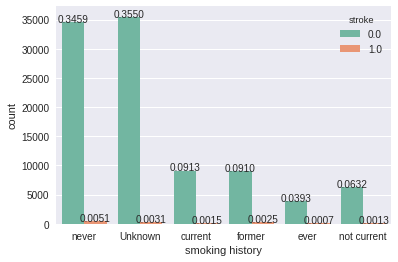

In [0]:
total_records=len(data_complete_df)
ax1 = sns.countplot(data=data_complete_df,x= data['smoking history'],hue="stroke",palette="Set2")
    
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
    height + 3,
    '{:1.4f}'.format(height/total_records,0),
    ha="center",rotation=0) 

# ** Models on upsampled data**

In [0]:
print("Number of Employees in X_train dataset: ", x_train.shape)
print("Number of Employees in y_train dataset: ", y_train.shape)
print("Number of Employees in X_test dataset: ", x_test.shape)
print("Number of Employees in y_test dataset: ", y_test.shape)

Number of Employees in X_train dataset:  (70000, 22)
Number of Employees in y_train dataset:  (70000,)
Number of Employees in X_test dataset:  (30000, 22)
Number of Employees in y_test dataset:  (30000,)


In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 993
Before OverSampling, counts of label '0': 69007 



In [0]:
X_train_res, y_train_res = sm.fit_sample(x_train, y_train.ravel())

In [0]:
print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))

After OverSampling, the shape of X_train: (138014, 22)
After OverSampling, the shape of y_train: (138014,) 



In [0]:
print("After OvererSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_res==0)))


After OvererSampling, counts of label '1': 69007
After OverSampling, counts of label '0': 69007 



In [0]:
models=[RandomForestClassifier(),AdaBoostClassifier(),BaggingClassifier(),LinearSVC(),
        KNeighborsClassifier(), DecisionTreeClassifier(),LogisticRegression(), GradientBoostingClassifier(), XGBClassifier(),GaussianNB(),BernoulliNB()]
model_names=['RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','LinearSVC',
             'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 
             'GradientBoostingClassifier', 'XGBClassifier','GaussianNB','BernoulliNB']
ROC_AUC_scores = []
F1_score=[]
mcc=[]

d={}

for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train_res, y_train_res)
    test_pred = clf.predict(x_test.as_matrix())
    ROC_AUC_scores.append(roc_auc_score(y_test, test_pred))
    F1_score.append(f1_score(y_test,test_pred))
    mcc.append(matthews_corrcoef(y_test,test_pred))
    
d={'Modelling Algo':model_names, 'ROC_AUC_Scores': ROC_AUC_scores,'F1_Score':F1_score,'MCC':mcc}   
df_models = pd.DataFrame(d)
df_models

,F1_Score,MCC,Modelling Algo,ROC_AUC_Scores
0,0.502924,0.500828,RandomForestClassifier,0.792256
1,0.345544,0.392546,AdaBoostClassifier,0.846632
2,0.488679,0.488337,BaggingClassifier,0.792853
3,0.089111,0.174167,LinearSVC,0.832084
4,0.168758,0.193704,KNeighborsClassifier,0.696712
5,0.452895,0.458114,DecisionTreeClassifier,0.794728
6,0.176083,0.267550,LogisticRegression,0.873681
7,0.386056,0.417767,GradientBoostingClassifier,0.831450
8,0.333691,0.380734,XGBClassifier,0.840182
9,0.405451,0.409302,GaussianNB,0.766321


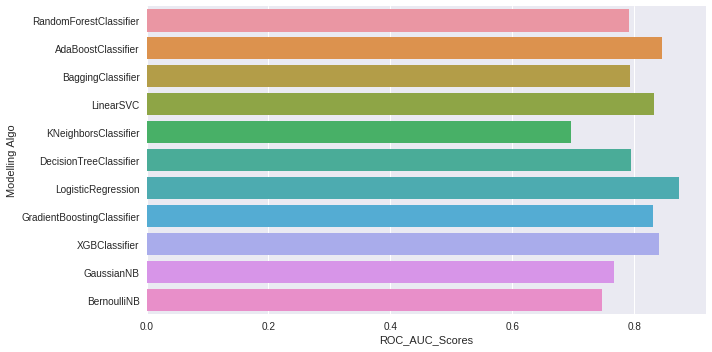

In [0]:
import seaborn as sns
sns.factorplot(y='Modelling Algo', x='ROC_AUC_Scores', data= df_models, kind = 'bar', size=5, aspect=2)

# Neural Network

In [0]:
from keras.layers import Dense,Input,BatchNormalization,Dropout
from keras.models import Model,K, Sequential
from keras.optimizers import SGD, rmsprop

In [0]:
K.clear_session()
def build_model():
  classifier = Sequential()
  classifier.add(Dense(output_dim=12,input_dim=22,init='uniform',activation='relu'))
  classifier.add(Dropout(rate=0.01))
  classifier.add(Dense(output_dim=12,input_dim=22,init='uniform',activation='relu'))
  classifier.add(Dropout(rate=0.01))
  classifier.add(Dense(output_dim=12,input_dim=22,init='uniform',activation='relu'))
  classifier.add(Dropout(rate=0.01))
  classifier.add(Dense(output_dim=12,input_dim=22,init='uniform',activation='relu'))
  classifier.add(Dropout(rate=0.01)) 
  classifier.add(Dense(output_dim=12,input_dim=22,init='uniform',activation='relu'))
  classifier.add(Dropout(rate=0.01)) 

  classifier.add(Dense(output_dim=1,input_dim=22,init='uniform',activation='sigmoid'))
  classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=[auc])
  return classifier

In [0]:
import tensorflow as tf
from keras import backend as K

def auc(y_test,y_pred_keras):
    auc = tf.metrics.auc(y_test, y_pred_keras)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(x_train, y_train, epochs=100, batch_size=100,verbose=1,validation_split=0.3)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Train on 49000 samples, validate on 21000 samples
Epoch 1/100
49000/49000 [==============================] - 3s 55us/step - loss: 0.1877 - auc: 0.4192 - val_loss: 0.0750 - val_auc: 0.4321
Epoch 2/100
49000/49000 [==============================] - 2s 37us/step - loss: 0.0684 - auc: 0.5215 - val_loss: 0.0661 - val_auc: 0.5971
Epoch 3/100
49000/49000 [==============================] - 2s 39us/step - loss: 0.0632 - auc: 0.6425 - val_loss: 0.0605 - val_auc: 0.6757
Epoch 4/100
49000/49000 [==============================] - 2s 36us/step - loss: 0.0537 - auc: 0.7024 - val_loss: 0.0483 - val_auc: 0.7232
Epoch 5/100
49000/49000 [============

In [0]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(x_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [0]:
print("ROC_AUC_Score :",roc_auc_score(y_test,y_pred_keras))
print("F1 Score :",f1_score(y_test,y_pred_keras.round()))
      

ROC_AUC_Score : 0.9500106268215665
F1 Score : 0.7093889716840537


In [0]:
print(classification_report(y_test,y_pred_keras.round()))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     29567
         1.0       1.00      0.55      0.71       433

   micro avg       0.99      0.99      0.99     30000
   macro avg       1.00      0.77      0.85     30000
weighted avg       0.99      0.99      0.99     30000



In [0]:
auc_keras = auc(fpr_keras, tpr_keras)

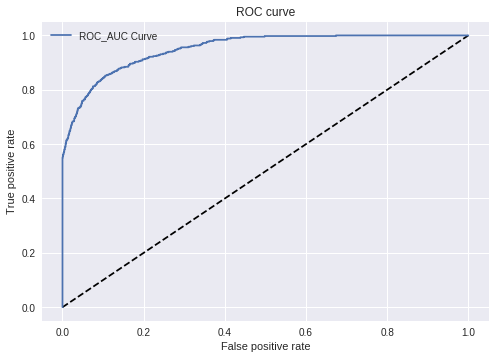

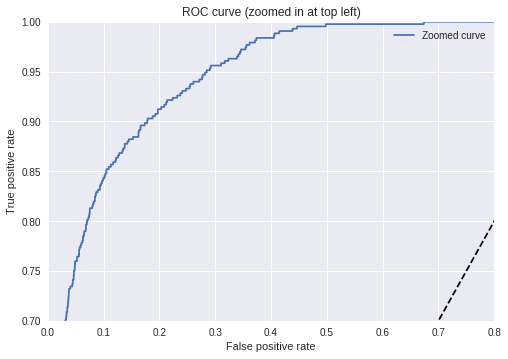

In [0]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras,label='ROC_AUC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.8)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras,label='Zoomed curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# Tuning

In [0]:
logic=LogisticRegression()
adaboost=AdaBoostClassifier()
xgboost=XGBClassifier()
gboost=GradientBoostingClassifier()
bagging=BaggingClassifier()
Gaussian=GaussianNB()
rf=RandomForestClassifier()
tree=DecisionTreeClassifier()

In [0]:
param_grid_logic={"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
param_grid_adaboost={'n_estimators':[50,100,200],'learning_rate':[0.0001,0.0003,0.0005]}
param_grid_xgboost={'n_estimators':[50,100,200],'learning_rate':[0.001,0.01,0.05,0.1],'max_depth':[3,5,7,9]}
param_grid_gboost={'n_estimators':[50,100,200],'learning_rate':[0.0001,0.0003,0.0005],'max_depth': [4, 6, 8,10]}
param_grid_bagg={'n_estimators':[50,100,200]}
param_grid_rf={'n_estimators':[50,100,200],'max_depth':[3,5,7,9]}
param_grid_tree = {'criterion' : ['entropy', 'gini'], 'max_depth' : [3,5,7,9]} # Grid of 8 values


In [0]:
best_model_logic = GridSearchCV(estimator=logic,param_grid=param_grid_logic,scoring='f1',n_jobs=-1,cv=5)
best_model_adaboost = GridSearchCV(estimator=adaboost,param_grid=param_grid_adaboost,scoring='f1',n_jobs=-1,cv=5)
best_model_xgboost = GridSearchCV(estimator=xgboost,param_grid=param_grid_xgboost,scoring='f1',n_jobs=-1,cv=5)
best_model_gboost = GridSearchCV(estimator=gboost,param_grid=param_grid_gboost,scoring='f1',n_jobs=-1,cv=5)
best_model_bagg = GridSearchCV(estimator=bagging,param_grid=param_grid_bagg,scoring='f1',n_jobs=-1,cv=5)
best_model_rf = GridSearchCV(estimator=rf,param_grid=param_grid_rf,scoring='f1',n_jobs=-1,cv=5)
best_model_tree = GridSearchCV(estimator=tree,param_grid=param_grid_tree,scoring='f1',n_jobs=-1,cv=5)


In [0]:
best_model_bagg.fit(X_train_res,y_train_res,)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
best_model_bagg.best_params_

{'n_estimators': 50}

In [0]:
best_model_bagg.best_score_

0.9869332805674895

In [0]:
cross_val_score(best_model_bagg.best_estimator_,X=X_train_res,y=y_train_res,cv=5)

array([0.97746703, 0.98974786, 0.98862401, 0.98971089, 0.98920368])

In [0]:
a=cross_val_score(best_model_bagg.best_estimator_,X=X_train_res,y=y_train_res,cv=5).mean()
a

0.9868347661573805

In [0]:
pred_bagg=best_model_bagg.predict(x_test)

In [0]:
f1_score(pred_bagg,y_test)

0.48821866163996236

In [0]:
matthews_corrcoef(pred_bagg,y_test)

0.487927928751812

In [0]:
best_model_rf.fit(X=X_train_res,y=y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
best_model_rf.best_params_

{'max_depth': 9, 'n_estimators': 200}

In [0]:
cross_val_score(best_model_rf.best_estimator_,X=X_train_res,y=y_train_res,cv=5)

array([0.93432111, 0.94214607, 0.94257662, 0.94174335, 0.94083762])

In [0]:
b=cross_val_score(best_model_rf.best_estimator_,X=X_train_res,y=y_train_res,cv=5).mean()
b

0.9396728432311727

In [0]:
best_model_tree.fit(X=X_train_res,y=y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
best_model_tree.best_params_

{'criterion': 'gini', 'max_depth': 9}

In [0]:
cross_val_score(best_model_tree.best_estimator_,X=X_train_res,y=y_train_res,cv=5)

array([0.92041009, 0.92602521, 0.92812115, 0.91986088, 0.9208753 ])

In [0]:
c=cross_val_score(best_model_tree.best_estimator_,X=X_train_res,y=y_train_res,cv=5).mean()
c

0.9230585256822079

In [0]:
score_model_names=['BaggingClassifier','RandomForestClassifier','Decision Tree']
cross_val_scores = [a,b,c]
best_models=[best_model_bagg,best_model_rf,best_model_tree]

ROC_AUC_scores_bm=[]
F1_score_bm=[]
mcc_bm=[]

for i in range(len(best_models)):
    bm = best_models[i]
    #bm.fit(x_train, y_train)
    y_pred = bm.predict(x_test)
    ROC_AUC_scores_bm.append(roc_auc_score(y_test, y_pred))
    F1_score_bm.append(f1_score(y_test,y_pred))
    mcc_bm.append(matthews_corrcoef(y_test,test_pred))


dictry={'Model':score_model_names,'Cross_Val_score':cross_val_scores,'F1 Score':F1_score_bm,'ROC_AUC':ROC_AUC_scores_bm,'MCC Score':mcc_bm}
score_df=pd.DataFrame(dictry)
print( "AFTER TUNING THE SCORES ARE :" )
score_df

AFTER TUNING THE SCORES ARE :


,Cross_Val_score,F1 Score,MCC Score,Model,ROC_AUC
0,0.986835,0.488219,0.246287,BaggingClassifier,0.792836
1,0.939673,0.275159,0.246287,RandomForestClassifier,0.847111
2,0.923059,0.264753,0.246287,Decision Tree,0.853896


# **Models on imbalanced dataset**

In [0]:
models=[RandomForestClassifier(),AdaBoostClassifier(),BaggingClassifier(),LinearSVC(),
        KNeighborsClassifier(), DecisionTreeClassifier(),LogisticRegression(), GradientBoostingClassifier(), XGBClassifier(),GaussianNB(),BernoulliNB()]
model_names=['RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','LinearSVC',
             'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 
             'GradientBoostingClassifier', 'XGBClassifier','GaussianNB','BernoulliNB']
ROC_AUC_scores = []
F1_score=[]
mcc=[]

d={}

for model in range(len(models)):
    clf = models[model]
    clf.fit(x_train, y_train)
    test_pred = clf.predict(x_test)
    ROC_AUC_scores.append(roc_auc_score(y_test, test_pred))
    F1_score.append(f1_score(y_test,test_pred))
    mcc.append(matthews_corrcoef(y_test,test_pred))
    
d={'Modelling Algo':model_names, 'ROC_AUC_Scores': ROC_AUC_scores,'F1_Score':F1_score,'MCC':mcc}   
df_models = pd.DataFrame(d)
df_models

,F1_Score,MCC,Modelling Algo,ROC_AUC_Scores
0,0.656676,0.663646,RandomForestClassifier,0.777276
1,0.708333,0.737373,AdaBoostClassifier,0.774810
2,0.667594,0.678401,BaggingClassifier,0.776358
3,0.709389,0.738953,LinearSVC,0.774827
4,0.116129,0.227217,KNeighborsClassifier,0.531093
5,0.535088,0.528624,DecisionTreeClassifier,0.777781
6,0.707463,0.737387,LogisticRegression,0.773672
7,0.702065,0.728092,GradientBoostingClassifier,0.774708
8,0.709389,0.738953,XGBClassifier,0.774827
9,0.405451,0.409302,GaussianNB,0.766321


In [0]:
y_train.value_counts()

0.0    69007
1.0      993
Name: stroke, dtype: int64

In [0]:
y_test.value_counts()

0.0    29567
1.0      433
Name: stroke, dtype: int64

In [0]:
pp=pd.DataFrame(test_pred,columns=['prediction'])
pp.head()

,prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [0]:
pp['prediction'].value_counts()

0.0    29663
1.0      337
Name: prediction, dtype: int64

In [0]:
xgb=XGBClassifier()
xgb.fit(x_train,y_train)
xg_pred=xgb.predict(x_test)

In [0]:
print(confusion_matrix(y_test,xg_pred))

[[29567     0]
 [  195   238]]


In [0]:
print(classification_report(y_test,xg_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     29567
         1.0       1.00      0.55      0.71       433

   micro avg       0.99      0.99      0.99     30000
   macro avg       1.00      0.77      0.85     30000
weighted avg       0.99      0.99      0.99     30000



In [0]:
f1_score(y_test,xg_pred)

0.7093889716840537

In [0]:
matthews_corrcoef(y_test,xg_pred)

0.7389534903813992

In [0]:
logic=LogisticRegression()
adaboost=AdaBoostClassifier()
xgboost=XGBClassifier()
gboost=GradientBoostingClassifier()
bagging=BaggingClassifier()
Gaussian=GaussianNB()
rf=RandomForestClassifier()
tree=DecisionTreeClassifier()

In [0]:
param_grid_logic={"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
param_grid_adaboost={'n_estimators':[50,100,200],'learning_rate':[0.0001,0.0003,0.0005]}
param_grid_xgboost={'n_estimators':[50,100,200],'learning_rate':[0.001,0.01,0.05,0.1],'max_depth':[3,5,7,9]}
param_grid_gboost={'n_estimators':[50,100,200],'learning_rate':[0.0001,0.0003,0.0005],'max_depth': [4, 6, 8,10]}
param_grid_bagg={'n_estimators':[50,100,200]}
param_grid_rf={'n_estimators':[50,100,200],'max_depth':[3,5,7,9]}
param_grid_tree = {'criterion' : ['entropy', 'gini'], 'max_depth' : [3,5,7,9]} # Grid of 8 values

In [0]:
best_model_logic = GridSearchCV(estimator=logic,param_grid=param_grid_logic,scoring='f1',n_jobs=-1,cv=5)
best_model_adaboost = GridSearchCV(estimator=adaboost,param_grid=param_grid_adaboost,scoring='f1',n_jobs=-1,cv=5)
best_model_xgboost = GridSearchCV(estimator=xgboost,param_grid=param_grid_xgboost,scoring='f1',n_jobs=-1,cv=5)
best_model_gboost = GridSearchCV(estimator=gboost,param_grid=param_grid_gboost,scoring='f1',n_jobs=-1,cv=5)
best_model_bagg = GridSearchCV(estimator=bagging,param_grid=param_grid_bagg,scoring='f1',n_jobs=-1,cv=5)
best_model_rf = GridSearchCV(estimator=rf,param_grid=param_grid_rf,scoring='f1',n_jobs=-1,cv=5)
best_model_tree = GridSearchCV(estimator=tree,param_grid=param_grid_tree,scoring='f1',n_jobs=-1,cv=5)


In [0]:
param_grid_xgboost={'n_estimators':[50,100,200],'learning_rate':[0.001,0.01,0.05,0.1],'max_depth':[3,5,7,9]}
best_model_xgboost = GridSearchCV(estimator=xgboost,param_grid=param_grid_xgboost,scoring='f1',n_jobs=-1,cv=5)


In [0]:
best_model_xgboost.fit(x_train,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.001, 0.01, 0.05, 0.1], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [0]:
cross_val_score(best_model_xgboost.best_estimator_,X=x_train,y=y_train,cv=5)

array([0.99271481, 0.99307192, 0.99314286, 0.99399957, 0.99292807])

In [0]:
cross_val_score(best_model_xgboost.best_estimator_,X=x_train,y=y_train,cv=5).mean()

0.9931714448701168

In [0]:
pp=best_model_xgboost.predict(x_test)

In [0]:
f1_score(y_test,pp)

0.7093889716840537

In [0]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=[('Boost',AdaBoostClassifier()),('Lr',LogisticRegression()), ('GBM',GradientBoostingClassifier()),('XGB',XGBClassifier())], voting='soft')
model.fit(x_train, y_train)
test_m_pred=model.predict(x_test)
#model.score(x_test,test_m_pred)
print("ROC_AUC_Score :",roc_auc_score(y_test, test_m_pred))
print("F1_Score :",f1_score(y_test,test_m_pred))
print("Matthews Coefficient :",matthews_corrcoef(y_test,test_m_pred))

ROC_AUC_Score : 0.7748267898383372
F1_Score : 0.7093889716840537
Matthews Coefficient : 0.7389534903813992


In [0]:
results=confusion_matrix(y_test,test_m_pred)

Text(0.5, 257.44, 'Predicted label')

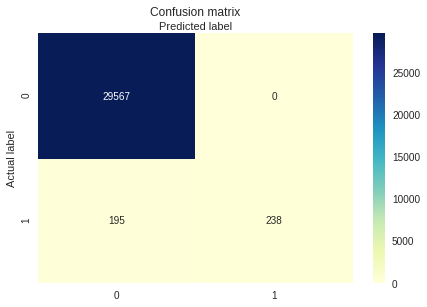

In [0]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(results), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [0]:
print(classification_report(y_test,test_m_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     29567
         1.0       1.00      0.55      0.71       433

   micro avg       0.99      0.99      0.99     30000
   macro avg       1.00      0.77      0.85     30000
weighted avg       0.99      0.99      0.99     30000



In [0]:
pred_df=pd.DataFrame(model.predict_proba(x_test))
pred_df.head()

,0,1
0,0.892481,0.107519
1,0.872216,0.127784
2,0.880955,0.119045
3,0.871553,0.128447
4,0.880766,0.119234


# ** Clustering**

In [0]:
!pip install pyclustering

    100% |████████████████████████████████| 2.1MB 11.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/d6/61/75/0f70c5f9e363b194b6bc197794c4376f72a550e9d5faf19958
Successfully built pyclustering


In [0]:
from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [0]:
data_complete_df.head()

,gender_Male,gender_Other,smoking history_current,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,...,diabetes & hypertension,diabetes & srtoke,diabetes & heart disease,hypertension & stroke,hypertension & heart disease,stroke & heart disease,"diabetes,hypertension,stroke","diabetes,hypertension,heart disease","hypertension,stroke,heart disease","hypertension,stroke,heart disease,diabetes"
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,76.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X_ct=pd.concat([x_train,y_train],axis=1)
print(X_ct.shape)
X_ct.head()

(70000, 23)


,gender_Male,gender_Other,smoking history_current,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,...,diabetes & srtoke,diabetes & heart disease,hypertension & stroke,hypertension & heart disease,stroke & heart disease,"diabetes,hypertension,stroke","diabetes,hypertension,heart disease","hypertension,stroke,heart disease","hypertension,stroke,heart disease,diabetes",stroke
41446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83682,1.0,0.0,0.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10698,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11748,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
!pip install kmedoids

  Could not find a version that satisfies the requirement kmedoids (from versions: )
No matching distribution found for kmedoids


In [0]:
import pyclustering.cluster.kmedoids
hc=AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='ward')
hc.fit(X_ct)

In [0]:
km=KMeans(n_clusters=5)

In [0]:
km.fit(X=X_ct)

#System crash 

NameError: ignored

In [0]:
km.inertia_

In [0]:
plt.plot(list(range(1,10)),ss)


#** Without interaction variables **

In [0]:
ndata=data_complete_df.drop(['diabetes & hypertension','diabetes & srtoke','diabetes & heart disease','hypertension & stroke','hypertension & heart disease','stroke & heart disease',
                            'diabetes,hypertension,stroke','diabetes,hypertension,heart disease','hypertension,stroke,heart disease'],axis=1)

In [0]:
ndata.shape

(100000, 14)

In [0]:
xx_train, xx_test, yy_train, yy_test = train_test_split(ndata.drop(['stroke'], axis= 1), 
                                                    ndata['stroke'], test_size=0.3, random_state=123)

In [0]:
models=[RandomForestClassifier(),AdaBoostClassifier(),BaggingClassifier(),LinearSVC(),
        KNeighborsClassifier(), DecisionTreeClassifier(),LogisticRegression(), GradientBoostingClassifier(), XGBClassifier(),GaussianNB(),BernoulliNB()]
model_names=['RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','LinearSVC',
             'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 
             'GradientBoostingClassifier', 'XGBClassifier','GaussianNB','BernoulliNB']
ROC_AUC_scores1 = []
F1_score1=[]
mcc1=[]

d={}

for model in range(len(models)):
    m = models[model]
    m.fit(xx_train, yy_train)
    test_pred1 = m.predict(xx_test)
    ROC_AUC_scores1.append(roc_auc_score(yy_test, test_pred1))
    F1_score1.append(f1_score(yy_test,test_pred1))
    #ck.append(cohen_kappa_score(y_test,test_pred))
    mcc1.append(matthews_corrcoef(yy_test,test_pred1))
    
d={'Modelling Algo':model_names, 'ROC_AUC_Scores': ROC_AUC_scores1,'F1_Score':F1_score1,'MCC':mcc1}   
df_models = pd.DataFrame(d)
df_models

,F1_Score,MCC,Modelling Algo,ROC_AUC_Scores
0,0.078231,0.082211,RandomForestClassifier,0.524065
1,0.057143,0.153488,AdaBoostClassifier,0.514756
2,0.075758,0.095435,BaggingClassifier,0.521612
3,0.057522,0.170857,LinearSVC,0.514806
4,0.008791,0.021232,KNeighborsClassifier,0.502041
5,0.092672,0.078578,DecisionTreeClassifier,0.541431
6,0.057522,0.170857,LogisticRegression,0.514806
7,0.056522,0.133219,GradientBoostingClassifier,0.514671
8,0.057522,0.170857,XGBClassifier,0.514806
9,0.112476,0.114141,GaussianNB,0.609183


# ** Under Sampling**

In [0]:
from imblearn.under_sampling import RandomUnderSampler

In [0]:
xx=x_train.values
yy=y_train.values
xx_testt=x_test.values
yy_testt=y_test.values

In [0]:
x_train.head()

,gender_Male,gender_Other,smoking history_current,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,...,BMI,diabetes & hypertension,diabetes & srtoke,diabetes & heart disease,hypertension & stroke,hypertension & heart disease,stroke & heart disease,"diabetes,hypertension,stroke","diabetes,hypertension,heart disease","hypertension,stroke,heart disease"
41446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,20.430000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83682,1.0,0.0,0.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,...,33.079747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10698,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,16.930000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11748,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.0,0.0,0.0,...,20.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,...,26.368814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
rus=RandomUnderSampler(return_indices=True)
X_rus,y_rus,id_rus=rus.fit_sample(xx,yy)

In [0]:
X_rus.shape

(1986, 22)

In [0]:
xxx=pd.DataFrame(X_rus)

xxx.columns=x_train.columns
xxx.head()

,gender_Male,gender_Other,smoking history_current,smoking history_ever,smoking history_former,smoking history_never,smoking history_not current,age,diabetes,hypertension,...,diabetes & hypertension,diabetes & srtoke,diabetes & heart disease,hypertension & stroke,hypertension & heart disease,stroke & heart disease,"diabetes,hypertension,stroke","diabetes,hypertension,heart disease","hypertension,stroke,heart disease","hypertension,stroke,heart disease,diabetes"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
yyy=pd.DataFrame(y_rus,columns=['stroke'])
yyy.head()


,stroke
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [0]:
yyy['stroke'].value_counts()

1.0    993
0.0    993
Name: stroke, dtype: int64

In [0]:
models=[RandomForestClassifier(),AdaBoostClassifier(),BaggingClassifier(),LinearSVC(),
        KNeighborsClassifier(), DecisionTreeClassifier(),LogisticRegression(), GradientBoostingClassifier(), XGBClassifier(),GaussianNB(),BernoulliNB()]
model_names=['RandomForestClassifier','AdaBoostClassifier','BaggingClassifier','LinearSVC',
             'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 
             'GradientBoostingClassifier', 'XGBClassifier','GaussianNB','BernoulliNB']
ROC_AUC_scores1 = []
F1_score1=[]
mcc1=[]

d={}

for model in range(len(models)):
    m = models[model]
    m.fit(xxx,yyy)
    test_pred1 = m.predict(x_test)
    ROC_AUC_scores1.append(roc_auc_score(y_test, test_pred1))
    F1_score1.append(f1_score(y_test,test_pred1))
    #ck.append(cohen_kappa_score(y_test,test_pred))
    mcc1.append(matthews_corrcoef(y_test,test_pred1))
    
d={'Modelling Algo':model_names, 'ROC_AUC_Scores': ROC_AUC_scores1,'F1_Score':F1_score1,'MCC':mcc1}   
df_models = pd.DataFrame(d)
df_models

,F1_Score,MCC,Modelling Algo,ROC_AUC_Scores
0,0.132634,0.214023,RandomForestClassifier,0.831815
1,0.127305,0.219382,AdaBoostClassifier,0.860652
2,0.136923,0.219556,BaggingClassifier,0.836492
3,0.273581,0.341473,LinearSVC,0.858409
4,0.081718,0.141699,KNeighborsClassifier,0.759658
5,0.098536,0.170521,DecisionTreeClassifier,0.797264
6,0.156116,0.249152,LogisticRegression,0.871178
7,0.145482,0.238498,GradientBoostingClassifier,0.867962
8,0.165935,0.258528,XGBClassifier,0.873159
9,0.515710,0.509175,GaussianNB,0.770565
